# Simple Classification Model for Text Messages
### David Lowe
### March 10, 2018

## Introduction and Preliminary Information
Methodology Credit: Re-produced and adapted from a tutorial made available by Evgeny VolkovSMS, Spam Detection with Various Classifiers (https://www.kaggle.com/muzzzdy/sms-spam-detection-with-various-classifiers).

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery (http://machinelearningmastery.com/).

Data Set Description: https://www.kaggle.com/uciml/sms-spam-collection-dataset

Original Reference: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

Modeling Approach: binary classification

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged according being ham (legitimate) or spam.

Working through machine learning problems from end-to-end requires a structured modeling approach. Working problems through a project template can encourage you to think about the problem more critically, to challenge your assumptions, and to get good at all parts of a modeling project.

Any predictive modeling machine learning project can be broken down into about 6 common tasks:

1. Define Problem
2. Summarize Data (Use the word cloud visualization technique for this project)
3. Prepare Data (Not required for this project)
4. Evaluate Algorithms (Use Naive Bayes classifier and measure accuracy)
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem
### 1.a) Load ibraries

In [234]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.b) Load dataset
Data: https://www.kaggle.com/uciml/sms-spam-collection-dataset/downloads/spam.csv/1

In [235]:
sms = pd.read_csv('kaggle_spam.csv', encoding='latin-1')
sms.head()
# Add appropriate labels to the columns.
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.
### 2.a) Descriptive statistics
#### 2.a.i) First, a peek at the data itself

In [236]:
sms.head(20)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


#### 2.a.ii) Distribution of the class attribute

In [237]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

#### 2.a.iii) Visualization of message length
Now let's create new feature "message length" and plot it to see if it's of any interest

In [238]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F812A98C88>,
      dtype=object)

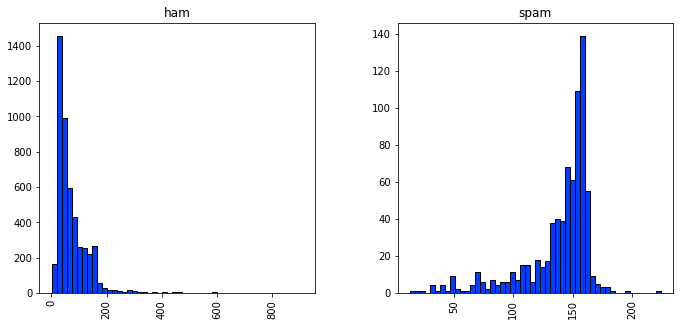

In [239]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

Preliminary observation: Many "ham" text messages are 100 characters or shorter, while most "spam" message are between 150 and 175 characters in length. 

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

For text processing, we will need to apply additional processing to remove punctuation and stopwords. We will generate a document feature matrix (DFM) which is a sparse matrix consisting of the frequency of words that occur in a document. The rows in DFM represent the document. The columns represent the words/terms of the sentence in the document as well as the frequency of its appearance in the document.

In [240]:
text_feat = sms['message'].copy()
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)
text_feat = text_feat.apply(text_process)
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

## Section 4. Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the dataset. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

We will be spot-checking a suite of linear and nonlinear machine learning algorithms and comparing the estimated accuracy of algorithms. For this project, we will evaluate 9 different algorithms:

Linear Algorithms: Logistic Regression (LR)

Nonliear Algorithms: Decision Tree (DTC), Support Vector Machine (SVC), Multinomial Native Bayes (MNB) and k-Nearest Neighbors (KNC)

Ensemble Algorithms: Random Forest (RFC), AdaBoost (ABC), Bagging (BC), and ExtraTree (ETC)

In [241]:
# Split the features to a training and testing set
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [242]:
# Import classifiers, initialize them, and make a dictionary to itereate through
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

In [243]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Parametres are based on notebook:
[Spam detection Classifiers hyperparameter tuning][1]


  [1]: https://www.kaggle.com/muzzzdy/d/uciml/sms-spam-collection-dataset/spam-detection-classifiers-hyperparameter-tuning/

In [244]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [245]:
# Train the classifiers and make predictions
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)
def predict_labels(clf, features):
    return (clf.predict(features))

Now iterate through classifiers and save the results

In [246]:
# Iterate through classifiers and save the results
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score'])
df

,Score
SVC,0.978469
KN,0.924641
NB,0.984450
DT,0.958732
LR,0.943182
RF,0.970096
AdaBoost,0.967105
BgC,0.967105
ETC,0.977273


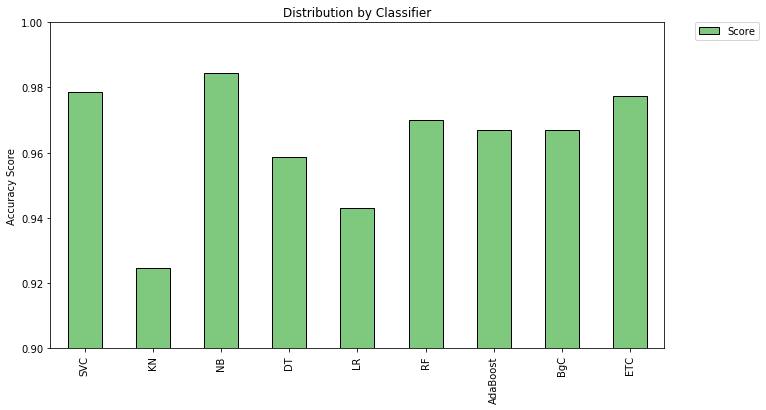

In [247]:
# Plot the initial prediction results by algorithms
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Preliminary Observation #1: The Multinomial Naive Bayes (MNB) algorithm appeared to produce the best results. The ensemble classifiers did well but not as well as MNB.

## Section 5. Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models:

* Search for a combination of parameters for each algorithm using caret that yields the best results.
* Combine the prediction of multiple models into an ensemble prediction using standalone algorithms or the caretEnsemble package.

### 5.a) Algorithm Tuning with Stemming

In [248]:
# Define the stemmer function
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

In [249]:
# Stem, split, fit, and predict!
text_feat = text_feat.apply(stemmer)
features = vectorizer.fit_transform(text_feat)
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [250]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [251]:
df2 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score2'])
df = pd.concat([df,df2],axis=1)
df

,Score,Score2
SVC,0.978469,0.978469
KN,0.924641,0.928230
NB,0.984450,0.985048
DT,0.958732,0.959928
LR,0.943182,0.946770
RF,0.970096,0.974880
AdaBoost,0.967105,0.970096
BgC,0.967105,0.968900
ETC,0.977273,0.977871


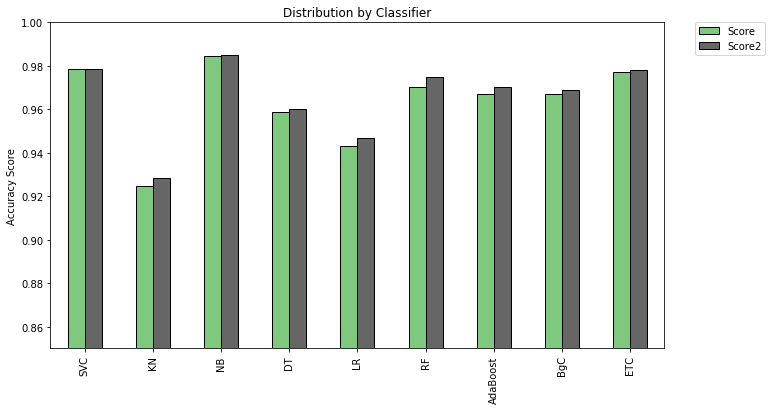

In [252]:
# Plot the prediction results by algorithms after stemming
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Preliminary Observation #2: The Multinomial Naive Bayes (MNB) algorithm continued to produce the best result. The ensemble classifiers did well but still not as well as MNB.

### 5.a) Algorithm Tuning with Message Length
We will append our message length feature to observe whether the classifiers would perform better with the extra piece of information

In [253]:
lf = sms['length'].as_matrix()
newfeat = np.hstack((features.todense(),lf[:, None]))
features_train, features_test, labels_train, labels_test = train_test_split(newfeat, sms['label'], test_size=0.3, random_state=111)

In [254]:
pred_scores = []
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))

In [255]:
df3 = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score3'])
df = pd.concat([df,df3],axis=1)
df

,Score,Score2,Score3
SVC,0.978469,0.978469,0.861244
KN,0.924641,0.928230,0.880383
NB,0.984450,0.985048,0.982656
DT,0.958732,0.959928,0.957536
LR,0.943182,0.946770,0.954545
RF,0.970096,0.974880,0.975478
AdaBoost,0.967105,0.970096,0.961722
BgC,0.967105,0.968900,0.962321
ETC,0.977273,0.977871,0.975478


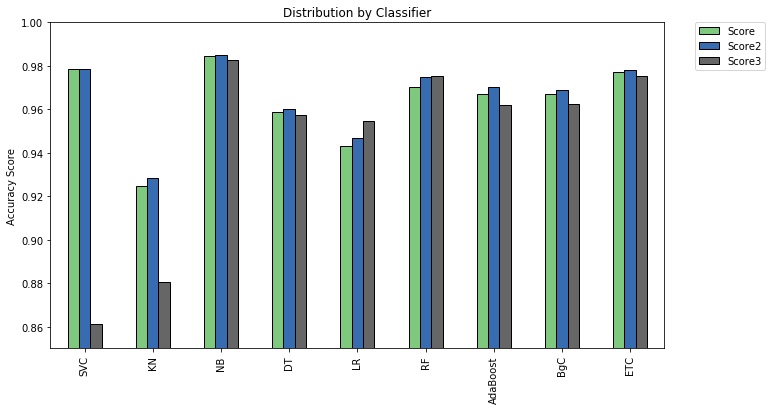

In [256]:
# Plot the prediction results by algorithms after applying the message length feature
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Final Conclusion: The Multinomial Naive Bayes (MNB) algorithm continued to produce the best result. MNB is the algorithm of choice for spam classification.